# Computing Reference Intervals for Healthy Sea Stars

In [1]:
%matplotlib inline
import math
import scipy.stats
import scipy.special
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read data from file
df = pd.read_csv('P_Ochraceus_Healthy_Values.csv')

# Remove columns with no data
df = df.dropna(how='all', axis=1)

# Define labels that we want to analyze statistically
cols_in = [
    'Magnesium (mg/dl)',
    'Sodium (mEq/L)',
    'Potassium (mEq/L)',
    'Chloride (mEq/L)',
    'Calcium (mg/dL)'
]

cols_out = [
    'Magnesium (mEq/L)',
    'Sodium (mEq/L)',
    'Potassium (mEq/L)',
    'Chloride (mEq/L)',
    'Calcium (mEq/L)'
]

# Convert units to SI. Source: https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470344484.app9
df = df[cols_in]
df['Magnesium (mEq/L)'] = df['Magnesium (mg/dl)'] * 0.882
df['Calcium (mEq/L)'] = df['Calcium (mg/dL)'] * 0.5
df = df[cols_out]

### Establish goodness of fit for each measurement
Plot data against lines at 2σ and 3σ. Then plot a histogram of the Box-Cox transformed data and compute the probability of the data belonging to a normal distribution.

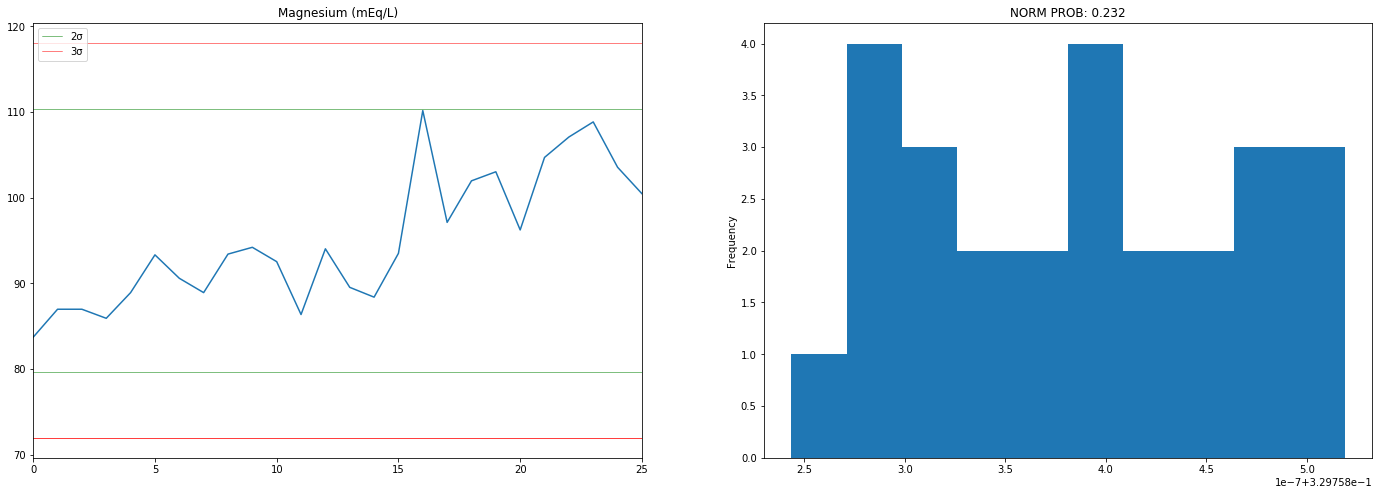

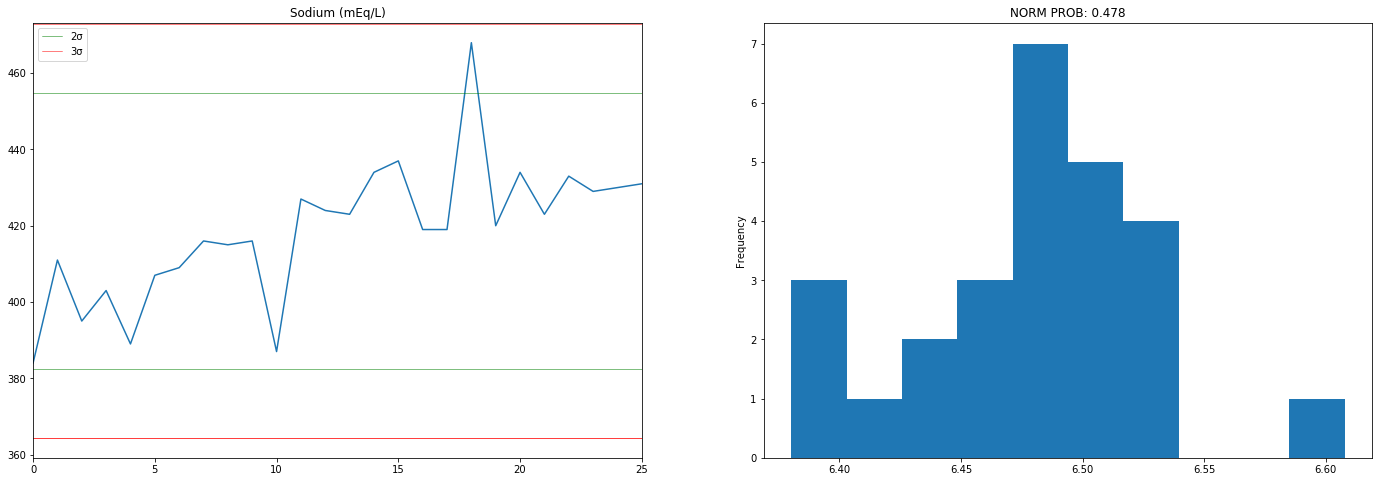

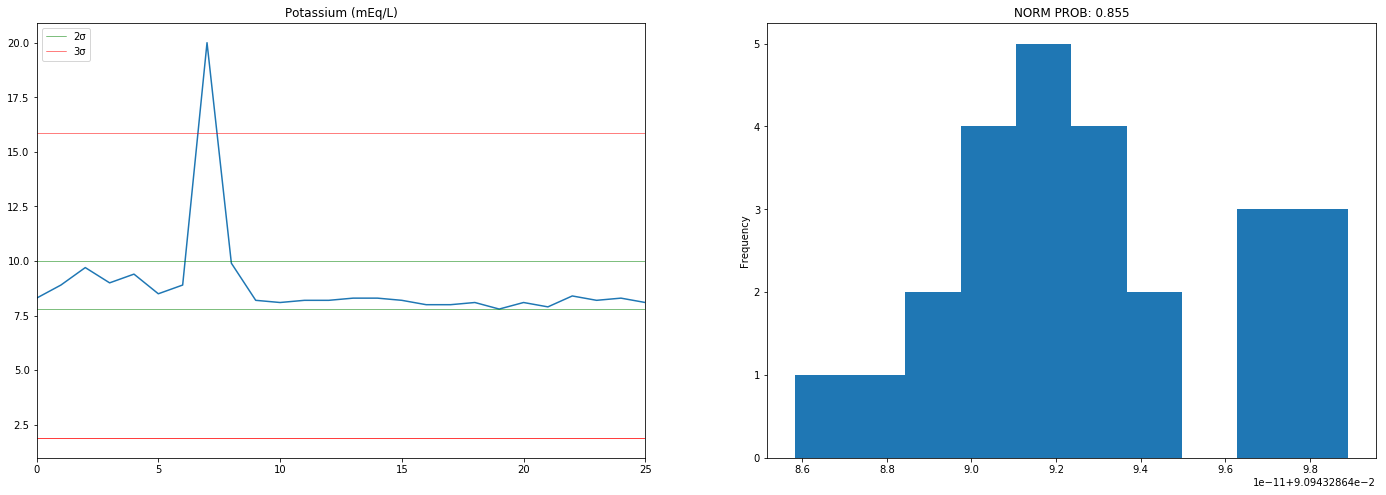

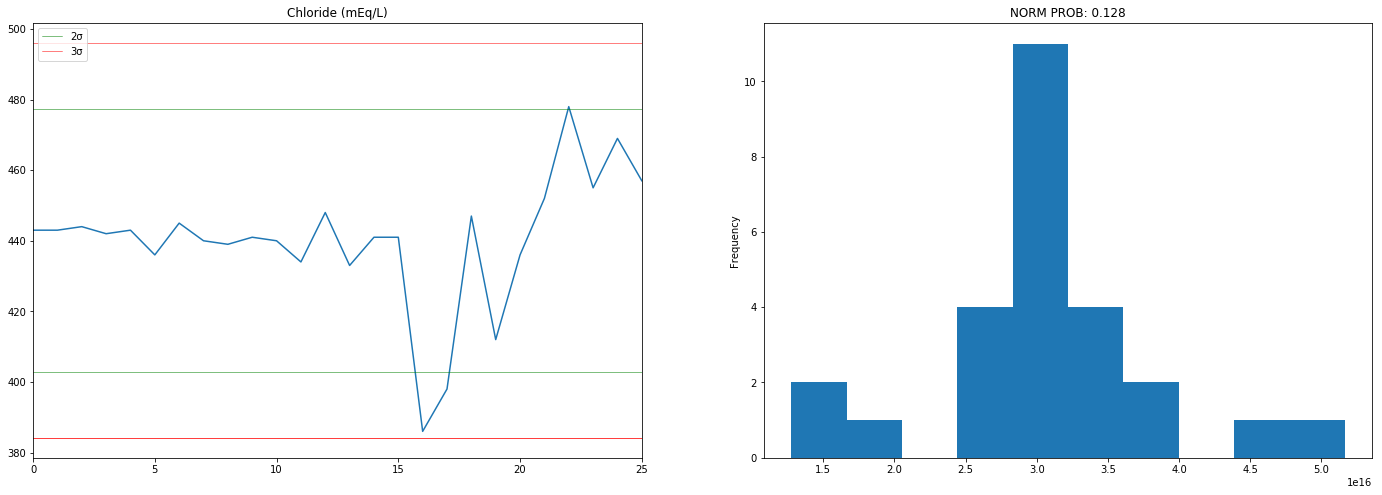

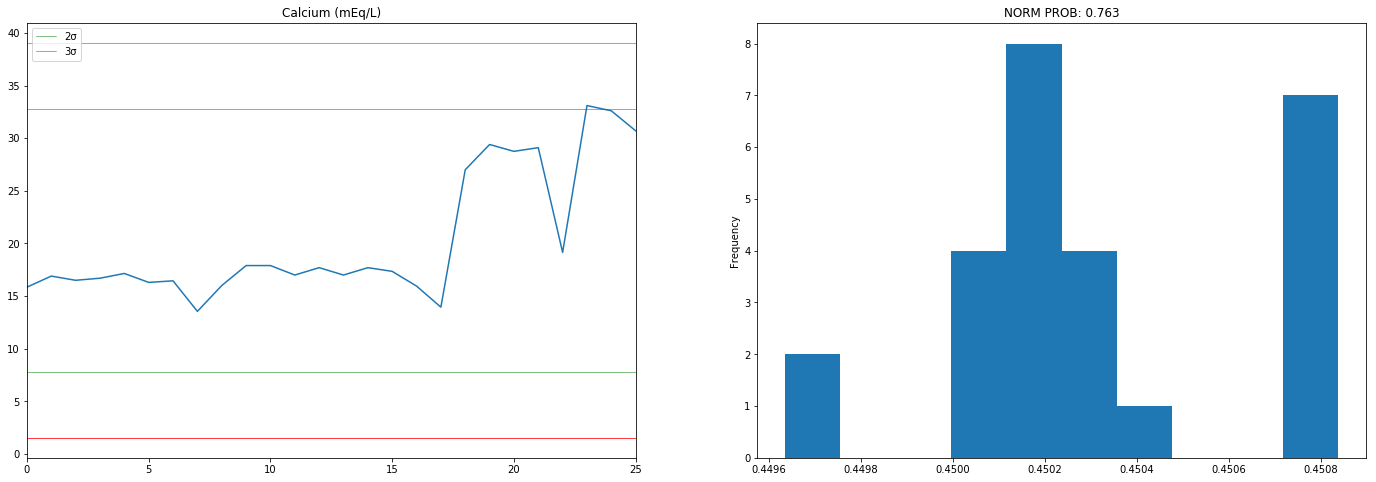

In [3]:
for col in df.columns:
    
    # Separate data for specific feature
    vec = df[col].copy()
    
    # Create 2 plots for each feature
    fig, axes = plt.subplots(figsize=(24,8), nrows=1, ncols=2)
    
    # Plot data against 3 * std over and under mean
    mean = vec.mean()
    std3 = vec.std() * 3
    ax = vec.plot(ax=axes[0], title=col)
    sigma3 = ax.axhline(y=mean-std3, c="red", linewidth=0.5, label='3σ')
    ax.axhline(y=mean-std3, c="red", linewidth=0.5)
    ax.axhline(y=mean+std3, c="red", linewidth=0.5)
    
    # Drop outliers
    vec[(vec > mean + std3) | (vec < mean - std3)] = np.nan
    vec.dropna(inplace=True)
    
    # Plot estimated upper and lower limits
    std2 = vec.std() * 2
    sigma2 = ax.axhline(y=mean-std2, c="green", linewidth=0.5, label='2σ')
    ax.axhline(y=mean+std2, c="green", linewidth=0.5)
    axes[0].legend(loc=2, handles=[sigma2, sigma3])

    # Plot data against gaussian distribution
    eps = 1E-2  # workaround for https://stats.stackexchange.com/a/306694/179192
    lmax = scipy.stats.boxcox_normmax(vec, brack=(-2 + eps, 2 - eps), method='mle')
    vec = pd.Series(scipy.stats.boxcox(vec, lmax))
    vec.plot(ax=axes[1], kind='hist')
    plt.title('NORM PROB: %.3f' % scipy.stats.mstats.normaltest(vec)[1])
    plt.show()


### Compute Reference Intervals
Compute max, min, mean, median and standard deviation on the raw data. Then perform a Box-Cox transformation, and compute the 90% and 95% reference interval on the transformed data. Lastly, inverse the transformation to get the resulting reference intervals in the original data.

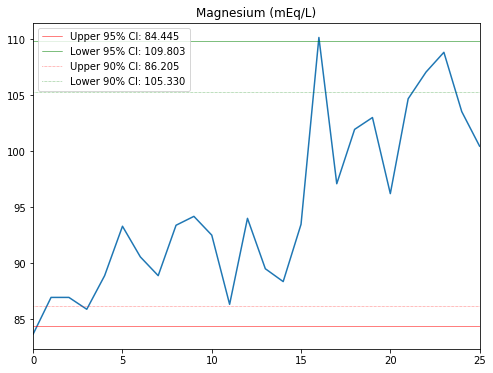

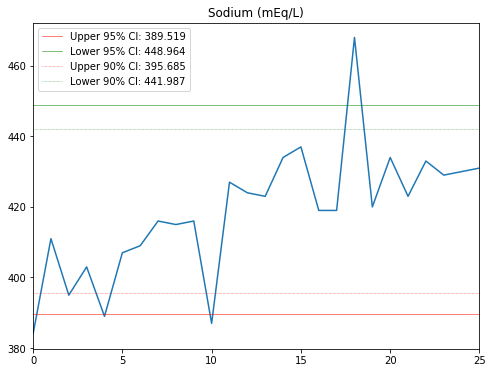

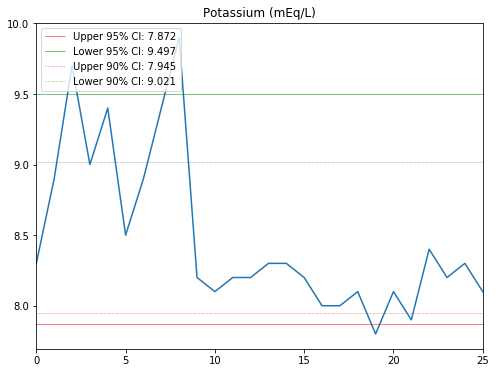

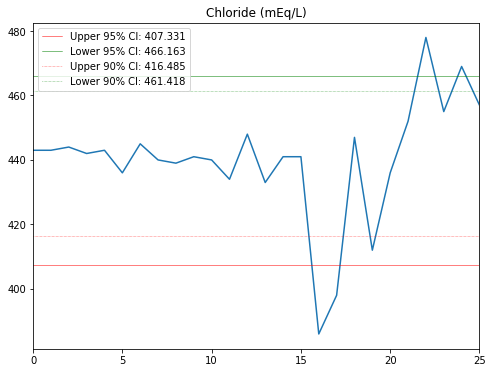

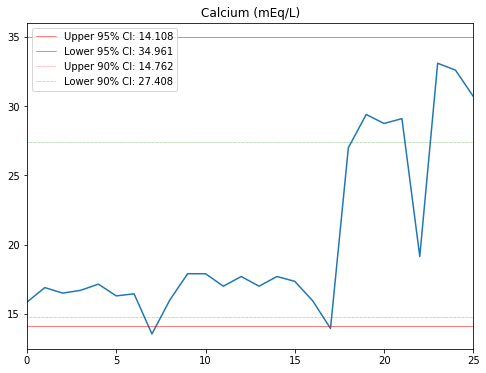

In [4]:
ri_records = []

for col in df.columns:
    
    # Separate data for specific feature
    vec = df[col].copy()
    
    # Drop outliers
    mean = vec.mean()
    std3 = vec.std() * 3
    vec[(vec > mean + std3) | (vec < mean - std3)] = np.nan
    vec.dropna(inplace=True)
    
    # Plot data prior to transformation
    ax = vec.plot(title=col, figsize=(8,6))
    
    # Compute variables not affected by transformation
    std = vec.std()
    vmax = vec.max()
    vmin = vec.min()
    mean = vec.mean()
    median = vec.median()
    
    # Transform data to approximate gaussian
    lmax = scipy.stats.boxcox_normmax(vec, brack=(-2 + eps, 2 - eps), method='mle')
    vec = pd.Series(scipy.stats.boxcox(vec, lmax))
    inv = lambda x: scipy.special.inv_boxcox(x, lmax)
    
    # Compute estimated upper and lower limits
    band90 = vec.std() * scipy.stats.norm.ppf(.90)
    band95 = vec.std() * scipy.stats.norm.ppf(.95)
    ci90 = (inv(vec.mean() - band90), inv(vec.mean() + band90))
    ci95 = (inv(vec.mean() - band95), inv(vec.mean() + band95))
    confidence = scipy.stats.t.interval(0.90, 10, loc=vec.mean(), scale=vec.std())
    confidence = (inv(confidence[0]), inv(confidence[1]))
    
    # Plot upper and lower limits against data
    hi1 = ax.axhline(y=ci95[0], c="red", linewidth=0.5, label='Upper 95%% CI: %.3f' % ci95[0])
    hi2 = ax.axhline(y=ci90[0], c="red", linestyle='dotted', linewidth=0.5, label='Upper 90%% CI: %.3f' % ci90[0])
    lo1 = ax.axhline(y=ci95[1], c="green", linewidth=0.5, label='Lower 95%% CI: %.3f' % ci95[1])
    lo2 = ax.axhline(y=ci90[1], c="green", linestyle='dotted', linewidth=0.5, label='Lower 90%% CI: %.3f' % ci90[1])
    plt.legend(loc=2, handles=[hi1, lo1, hi2, lo2])
    plt.show()
    
    # Store in records
    ri_records.append((col, ci90, ci95, mean, median, vmax, vmin, std))


### Output Computed Reference Intervals

In [5]:
pd.DataFrame(ri_records, columns=(
    'Measurement', '90% Confidence Interval', '95% Confidence Interval',
    'Mean', 'Median', 'Max', 'Min', 'Std Dev')).set_index('Measurement')

90% Confidence Interval  \
Measurement                                                   
Magnesium (mEq/L)   (86.20519901249203, 105.32953526906749)   
Sodium (mEq/L)       (395.6854950418216, 441.9867358737919)   
Potassium (mEq/L)    (7.945228325281441, 9.021469380264437)   
Chloride (mEq/L)    (416.48549660417365, 461.4176897070263)   
Calcium (mEq/L)    (14.762400590709303, 27.407571809028624)   

                                    95% Confidence Interval        Mean  \
Measurement                                                               
Magnesium (mEq/L)   (84.44545022762075, 109.80290666985357)   95.008362   
Sodium (mEq/L)        (389.518517959005, 448.9638005445808)  418.576923   
Potassium (mEq/L)      (7.8723233950313, 9.496541733182806)    8.440000   
Chloride (mEq/L)   (407.33104135423866, 466.16320754644005)  440.115385   
Calcium (mEq/L)    (14.107794216779377, 34.961483998203626)   20.294231   

                     Median       Max       Min    Std Dev  
Measurement                                                 
Magnesium (mEq/L)   93.4479  110.1618   83.7018   7.694317  
Sodium (mEq/L)     419.5000  468.0000  384.0000  18.084630  
Potassium (mEq/L)    8.2000    9.9000    7.8000   0.551513  
Chloride (mEq/L)   441.5000  478.0000  386.0000  18.668320  
Calcium (mEq/L)     17.2500   33.1000   13.5500   6.259334